In [1]:
import os
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.nn import sigmoid, relu
from jax.tree_util import tree_map

import optax
import functools

import torch
from torch.utils import data

In [2]:
import matplotlib.pyplot as plt

In [3]:
import util as U

# Load data

In [4]:
iwave = 1

In [7]:
_thetas, _t_ages = [], [] 
for i in range(10): 
    _thetas.append(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.thetas_sps.npz' % i))['arr_0'])
    _t_ages.append(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.tages.npz' % i))['arr_0'])    
_thetas = np.concatenate(_thetas, axis=0)    
_t_ages = np.concatenate(_t_ages, axis=0)
_thetas = np.concatenate([_thetas, _t_ages[:,None]], axis=1)

In [8]:
avg_thetas = np.mean(_thetas, axis=0)
std_thetas = np.std(_thetas, axis=0)
thetas = (_thetas - avg_thetas)/std_thetas

In [9]:
_x_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.x_pca.w%i.npy' % iwave))

In [10]:
avg_x_pca = np.mean(_x_pca, axis=0)
std_x_pca = np.std(_x_pca, axis=0)
x_pca = (_x_pca - avg_x_pca)/std_x_pca

In [11]:
def numpy_collate(batch):
    return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.ravel(np.array(pic, dtype=jnp.float32))

In [12]:
N_train = int(0.9*x_pca.shape[0])
train_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[:N_train]), torch.tensor(x_pca[:N_train])), batch_size=500)
valid_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[N_train:]), torch.tensor(x_pca[N_train:])), batch_size=500)

# set up MLP in jax

In [13]:
def nonlin_act(x, beta, gamma):
    return (gamma + sigmoid(beta * x) * (1 - gamma)) * x

def init_mlp_params(layer_sizes, scale=1e-2):
    keys = random.split(random.PRNGKey(1), len(layer_sizes))

    params = []
    for i, key in zip(np.arange(len(layer_sizes)-2), keys): 
        m, n = layer_sizes[i], layer_sizes[i+1]
        #w_key, b_key = random.split(key, num=2)
        #params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
        w_key, b_key, _a_key, _b_key = random.split(key, num=4)
        params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,)), 
                      scale * random.normal(_a_key, (n,)), scale * random.normal(_b_key, (n,))])

    m, n = layer_sizes[-2], layer_sizes[-1]        
    w_key, b_key = random.split(keys[-1], num=2)
    params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
    return params

@functools.partial(jax.vmap, in_axes=(None, 0))
def forward(params, inputs):
    activations = inputs
    #for w, b in params[:-1]:
    for w, b, beta, gamma in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = nonlin_act(outputs, beta, gamma) #relu(outputs)#

    final_w, final_b = params[-1]
    return jnp.dot(final_w, activations) + final_b

def mse_loss(params, inputs, targets):
    preds = forward(params, inputs)
    return jnp.mean((preds - targets) ** 2)

# train using `optax`

In [14]:
# Update function
@jit
def update(params, opt_state, inputs, targets):
    loss, grads = jax.value_and_grad(mse_loss)(params, inputs, targets)
    updates, opt_state = gradient_transform.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    #updates, opt_state = optimizer.update(grads, opt_state)
    #params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [15]:
layer_sizes = [thetas.shape[1], 512, 512, 512, x_pca.shape[1]]
learning_rate = 1e-2
n_epochs = 1000

# Initialize the MLP and optimizer
params = init_mlp_params(layer_sizes)
optimizer = optax.adam(learning_rate)

total_steps = n_epochs*len(train_dataloader)
scheduler = optax.exponential_decay(init_value=learning_rate, 
                                    transition_steps=total_steps, 
                                    transition_begin=int(total_steps*0.25),
                                    decay_rate=0.01)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

# Initialize optimizer state
#opt_state = optimizer.init(params)
opt_state = gradient_transform.init(params)


# Training loop
train_loss, valid_loss, best_valid_loss, best_epoch = [], [], np.inf, 0
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x, y in train_dataloader:        
        params, opt_state, loss = update(params, opt_state, x, y)        
        epoch_loss += loss
    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)
    
    _loss = 0.
    for x, y in valid_dataloader: 
        loss = mse_loss(params, x, y)
        _loss += loss
    valid_loss.append(_loss/len(valid_dataloader))

    # early stopping after 20 epochs
    if valid_loss[-1] < best_valid_loss: 
        best_valid_loss = valid_loss[-1]
        best_epoch = epoch
        best_params = params.copy()

    if epoch > best_epoch + 20: 
        break

    if epoch % 10 == 0: print(f"Epoch {epoch}, Loss: {epoch_loss}, Valid Loss: {valid_loss[-1]}")

2024-04-24 07:13:28.343859: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Epoch 0, Loss: 0.37362176179885864, Valid Loss: 0.24705392122268677
Epoch 10, Loss: 0.1385112702846527, Valid Loss: 0.15144559741020203
Epoch 20, Loss: 0.11963596194982529, Valid Loss: 0.12520112097263336
Epoch 30, Loss: 0.10960288345813751, Valid Loss: 0.11973569542169571
Epoch 40, Loss: 0.10355164855718613, Valid Loss: 0.11254925280809402
Epoch 50, Loss: 0.09860151261091232, Valid Loss: 0.10777720808982849
Epoch 60, Loss: 0.09614824503660202, Valid Loss: 0.10579792410135269
Epoch 70, Loss: 0.09283198416233063, Valid Loss: 0.09487646073102951
Epoch 80, Loss: 0.09133774787187576, Valid Loss: 0.09498399496078491
Epoch 90, Loss: 0.08901312202215195, Valid Loss: 0.0937497466802597
Epoch 100, Loss: 0.08823955804109573, Valid Loss: 0.09220709651708603
Epoch 110, Loss: 0.08702795207500458, Valid Loss: 0.08713795244693756
Epoch 120, Loss: 0.0857371985912323, Valid Loss: 0.09076584875583649
Epoch 130, Loss: 0.08570664376020432, Valid Loss: 0.08976391702890396
Epoch 140, Loss: 0.085326582193374

In [16]:
forward(best_params, np.array([thetas[0]]))

Array([[ 0.30544683, -1.0985299 , -0.6225617 ,  0.8211838 , -0.67987406,
        -0.75842166,  0.20826983, -0.2952221 , -0.49112564,  0.66250837,
        -0.22825181,  0.68429524, -0.64100736, -0.76408315, -0.8576699 ,
        -0.3410589 , -0.72494614,  1.0853207 ,  0.03257096,  0.46615154,
         0.03230554,  0.10021716, -1.3587847 ,  0.8191849 ,  0.40436512,
        -0.17368937, -0.34954864, -0.5945807 ,  0.13967782,  0.52117205,
        -0.03792303,  0.9510486 , -1.468627  , -0.9420044 ,  0.37634468,
        -0.11561026,  0.46595103, -0.06456767,  0.96532106, -0.41958168,
        -1.0010083 ,  0.43346626,  0.8405904 , -0.923341  , -0.6613994 ,
        -1.2857317 ,  0.71580684,  0.6898802 , -0.07762536,  0.44860843]],      dtype=float32)

In [17]:
x_pca[0]

array([ 0.30943524, -1.13289034, -0.6653249 ,  0.81677219, -0.64704121,
       -0.69456442,  0.28655735, -0.27562407, -0.44432556,  0.62977647,
       -0.20037988,  0.57277916, -0.67910717, -0.66117903, -0.82910167,
       -0.3129925 , -0.61549791,  1.05481832,  0.2210822 ,  0.22595005,
       -0.14898076,  0.05213284, -1.38782921,  0.60607091,  0.41044452,
       -0.12768584, -0.13348063, -0.57776957,  0.1525249 ,  0.47004961,
       -0.05956924,  0.85542953, -1.33422384, -0.72609636,  0.29622136,
        0.14193092,  0.33000221,  0.14298564,  0.865948  , -0.39399038,
       -0.72042464,  0.39615588,  0.80161837, -0.79733654, -0.12604371,
       -1.12663324,  0.70457986,  0.54110416, -0.06183649,  0.53769653])

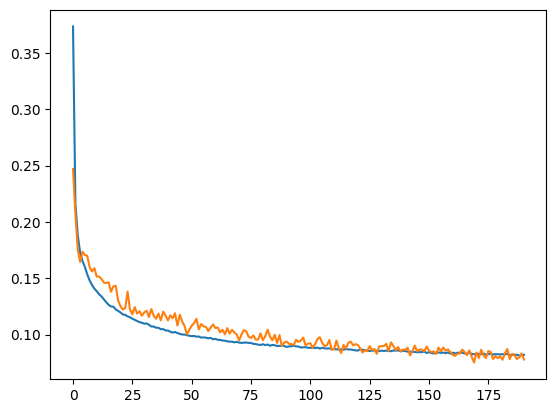

In [19]:
plt.plot(train_loss)
plt.plot(valid_loss)

# validate trained NN

In [26]:
M_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.M_pca.w%i.npy' % iwave))
avg_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.avg_logseds.w%i.npy' % iwave))
std_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.std_logseds.w%i.npy' % iwave))

In [21]:
wave_bins = [(1.5e3, 3.525e3), 
             (3.525e3, 5.5e3), (5.5e3, 7.5e3), # these wavelength ranges are determined by the MILES spectral library wavelength (3525 - 7500)
             (7.5e3, 4e5)]
wave_bin = wave_bins[iwave]

_w = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.0.waves.npz'))['arr_0'][0]
wlim = np.ones(len(_w)).astype(bool)
if wave_bin[0] is not None: wlim &= (_w > wave_bin[0])
if wave_bin[1] is not None: wlim &= (_w < wave_bin[1])   
    
theta_test = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.999.thetas_sps.npz'))['arr_0']
t_age_test = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.999.tages.npz'))['arr_0']
logsed = np.log10(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.999.seds.npz'))['arr_0'][:,wlim])

In [28]:
dlogsed = []
for i in range(logsed.shape[0]): 
    _theta = np.concatenate([theta_test[i], [t_age_test[i]]])
    _wtheta = (_theta - avg_thetas)/std_thetas

    _y_pred = forward(best_params, np.array([_wtheta]))

    _y_pred *= std_x_pca
    _y_pred += avg_x_pca

    _logsed_pred = np.dot(_y_pred, M_pca) * std_logsed + avg_logsed
    dlogsed.append((10**logsed[i] - 10**_logsed_pred)/10**logsed[i])

(-0.1, 0.1)

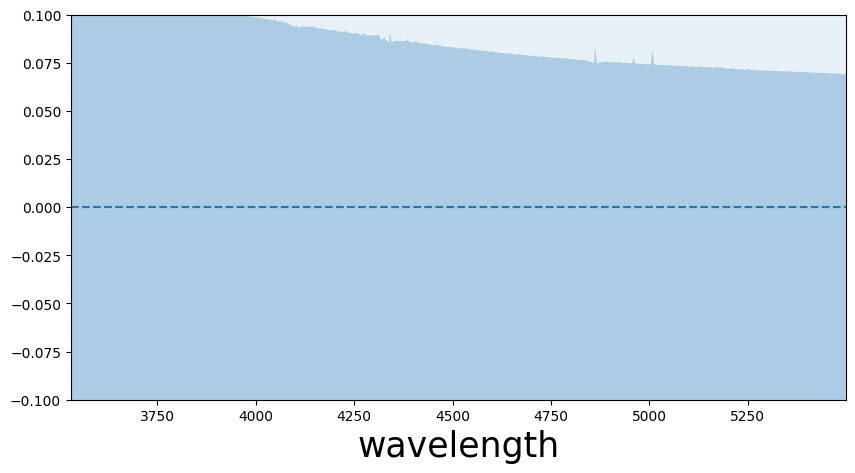

In [33]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

q0, q1, q2, q3 = np.quantile(dlogsed, [0.025, 0.16, 0.84, 0.975], axis=0)


sub.fill_between(_w[wlim], q0[0], q3[0], color='C0', edgecolor='none', alpha=0.1) 
sub.fill_between(_w[wlim], q1[0], q2[0], color='C0', edgecolor='none', alpha=0.3) 
sub.plot([_w[wlim].min(), _w[wlim].max()], [0., 0.], c='C0', ls='--')

sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(_w[wlim].min(), _w[wlim].max())

sub.set_ylim(-0.1, 0.1)